In [39]:
import matplotlib
import matplotlib.pyplot as plt
from common.classification import k_neighbours_leave_one_out, decision_tree_leave_one_out
from common.clustering import k_means_multiple_dim_clustering, \
    plot_means_in_clusters_for_given_column, \
    k_means_multiple_dim_silhouette, hierarchical_multiple_dim_silhouette, plot_clustering_scores, \
    perform_clustering_score_analysis
from common.outliers import find_outliers_in_multiple_columns, plot_2d_data_with_outliers, drop_outliers_from_dataset
from common.standardization import standardize, de_standardize
import pandas as pd
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Dataset loading and preparation
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [40]:
second_sales = "EU_Sales"

# load dataset from file
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)

# choose 7th gen consoles
print(data["Platform"].unique())
seventh_gen = ["PS3", "Wii", "X360"]
data = data.loc[data["Platform"].isin(seventh_gen)]

# remove unused columns
columns_used_for_clustering = ["Critic_Score", "NA_Sales", second_sales]
categorical_columns = ["Platform", "Genre", "Rating"]
data = data.filter(items=[*columns_used_for_clustering, *categorical_columns])

# compute stats for each column
stats_to_compute = ["max", "min", "std", "mean", "median"]
columns_stats = data.agg({item: stats_to_compute for item in columns_used_for_clustering})

['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG']


### Helper plots

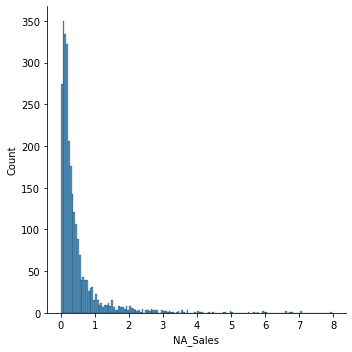

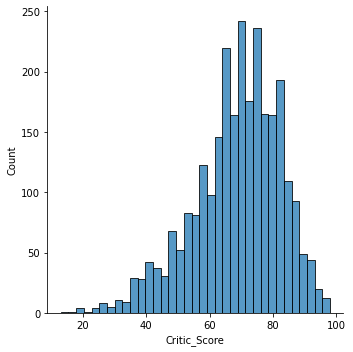

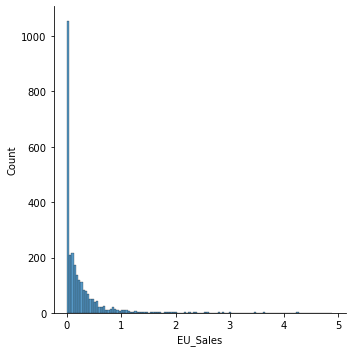

In [41]:
sns.displot(data[data["NA_Sales"] < 8], x="NA_Sales")
sns.displot(data, x="Critic_Score")
sns.displot(data[data[second_sales] < 5], x=second_sales)

### Data standardization

In [42]:
standardize(data, columns_used_for_clustering, columns_stats)

### Detect and drop outliers

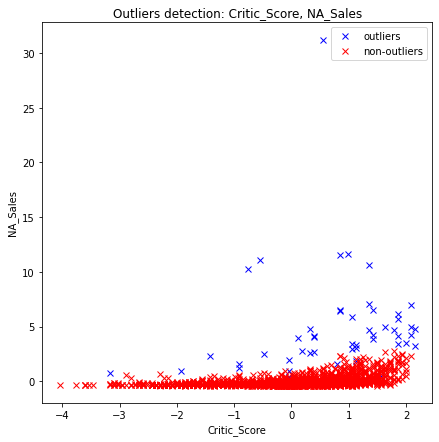

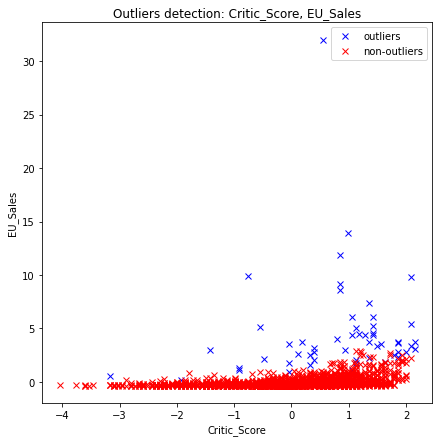

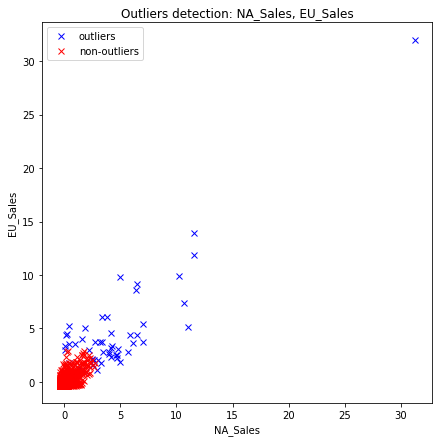

In [43]:
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

plot_2d_data_with_outliers(outliers, non_outliers, ("Critic_Score", "NA_Sales"))
plot_2d_data_with_outliers(outliers, non_outliers, ("Critic_Score", second_sales))
plot_2d_data_with_outliers(outliers, non_outliers, ("NA_Sales", second_sales))

data = drop_outliers_from_dataset(data, outliers)

### Clustering - results for different amounts of clusters

Performing Silhouette score analysis ... 

Used method: K-Means
Score for 2 clusters 0.45379413503032967 (+-0.00037835476801447636)
Score for 3 clusters 0.4141742595277695 (+-5.45864055466863e-05)
Score for 4 clusters 0.4286774205156386 (+-0.00032062150953076355)
Score for 5 clusters 0.3807755178901148 (+-0.0037321434427963836)
Score for 6 clusters 0.3662412543264554 (+-0.012698974923240963)
Score for 7 clusters 0.3554413483263937 (+-0.00248547520957142)
Score for 8 clusters 0.36305202734488595 (+-0.0017731104352305355)
Score for 9 clusters 0.33762236745420066 (+-0.002026123482357763)
Score for 10 clusters 0.33867022009655645 (+-0.0066215811238652085)
Score for 11 clusters 0.3247691529969483 (+-0.002082391015867571)
Score for 12 clusters 0.3286628084485227 (+-0.007471279319228598)
Score for 13 clusters 0.3183724127489281 (+-0.006217153416188106)
Score for 14 clusters 0.32121549949327505 (+-0.00319696945463785)
Score for 15 clusters 0.3126065777896958 (+-0.009325177846047342)
Score for 

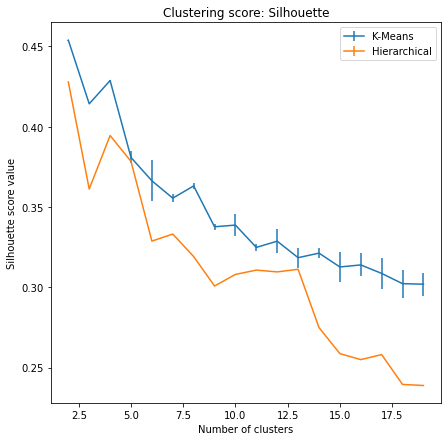

In [44]:
print("Performing Silhouette score analysis ... ")
numbers_of_clusters = range(2, 20)

print("\nUsed method: K-Means")
k_means_scores, k_means_errors = \
    perform_clustering_score_analysis(data, columns_used_for_clustering, numbers_of_clusters,
                                      k_means_multiple_dim_silhouette, outliers, 10)

print("\nUsed method: Hierarchical")
hierarchical_scores, hierarchical_errors = \
    perform_clustering_score_analysis(data, columns_used_for_clustering, numbers_of_clusters,
                                      hierarchical_multiple_dim_silhouette, outliers, 2)

scores = [k_means_scores, hierarchical_scores]
errors = [k_means_errors, hierarchical_errors]
methods = ["K-Means", "Hierarchical"]
plot_clustering_scores(numbers_of_clusters, scores, errors, methods, "Silhouette")


### Clustering - 4 clusters

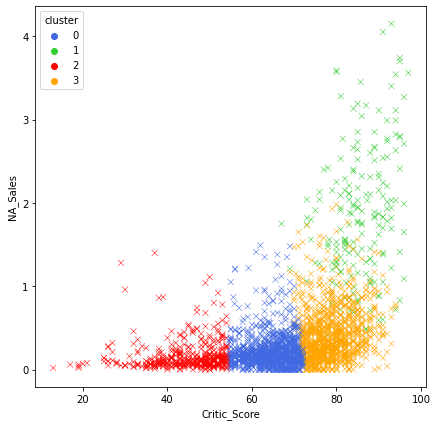

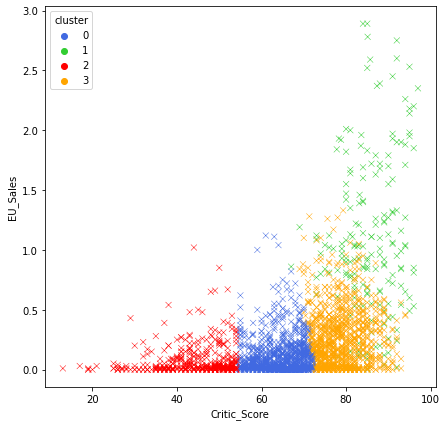

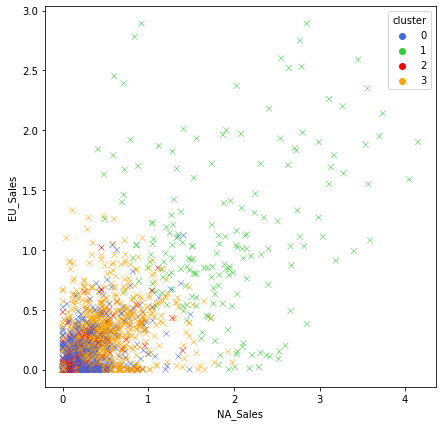

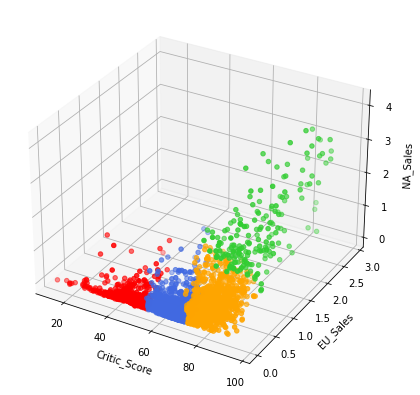

In [45]:
palette = ["royalblue", "limegreen", "red", "orange"]
clustered_data = k_means_multiple_dim_clustering(data, columns_used_for_clustering, 4)
de_standardize(clustered_data, columns_used_for_clustering, columns_stats)

sns.scatterplot(data=clustered_data, x="Critic_Score", y="NA_Sales", hue="cluster", palette=palette, marker='x')
plt.show()

sns.scatterplot(data=clustered_data, x="Critic_Score", y=second_sales, hue="cluster", palette=palette, marker='x')
plt.show()

sns.scatterplot(data=clustered_data, x="NA_Sales", y=second_sales, hue="cluster", palette=palette, marker='x')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
number_of_clusters = clustered_data["cluster"].max() + 1
for cluster_index in range(0, number_of_clusters):
    cluster_data = clustered_data[clustered_data["cluster"] == cluster_index]
    ax.scatter(cluster_data["Critic_Score"], cluster_data[second_sales], cluster_data["NA_Sales"], c=palette[cluster_index])

ax.set_xlabel('Critic_Score')
ax.set_ylabel(second_sales)
ax.set_zlabel('NA_Sales')
plt.show()

### Clusters analysis - variables distributions for each cluster

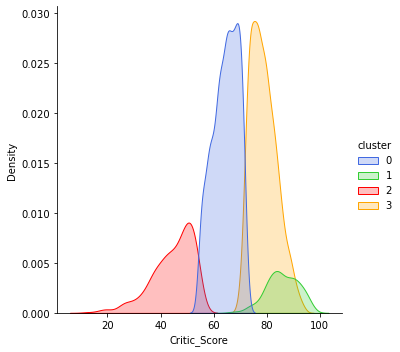

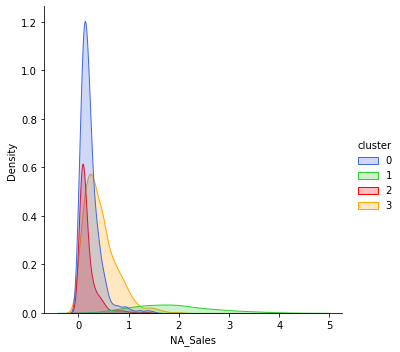

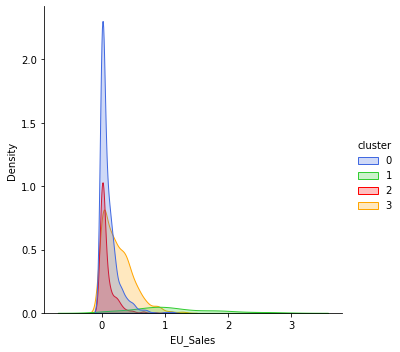

In [46]:
sns.displot(clustered_data, x="Critic_Score", hue="cluster", kind="kde", fill=True, palette=palette)
sns.displot(clustered_data, x="NA_Sales", hue="cluster", kind="kde", fill=True, palette=palette)
sns.displot(clustered_data, x="EU_Sales", hue="cluster", kind="kde", fill=True, palette=palette)

### Clusters analysis - variables means for each cluster

         Critic_Score  NA_Sales  EU_Sales
cluster                                  
0           64.408302  0.221409  0.102444
1           85.726882  1.886183  1.115000
2           44.497087  0.170121  0.076699
3           78.732293  0.427766  0.256449


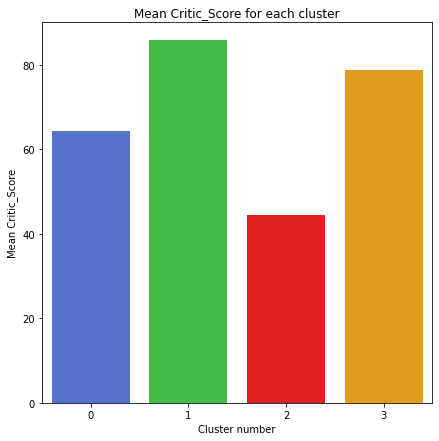

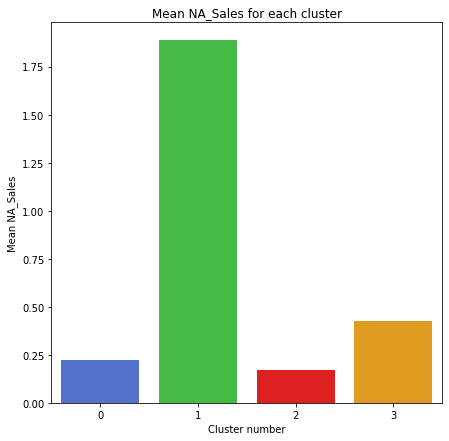

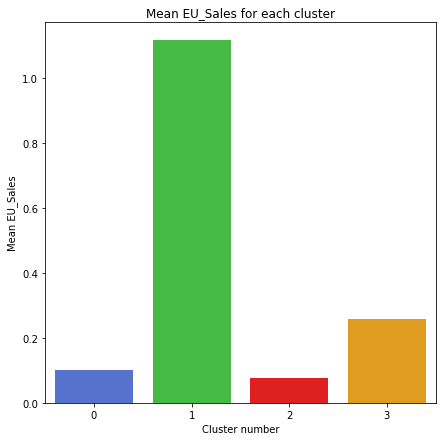

In [47]:
data_means_grouped_by_clusters = clustered_data.groupby("cluster").mean()
print(data_means_grouped_by_clusters)

plot_means_in_clusters_for_given_column(clustered_data, "Critic_Score", colors=palette)
plot_means_in_clusters_for_given_column(clustered_data, "NA_Sales", colors=palette)
plot_means_in_clusters_for_given_column(clustered_data, second_sales, colors=palette)

### Clusters analysis - categorical variables

<AxesSubplot:xlabel='counts', ylabel='Rating'>

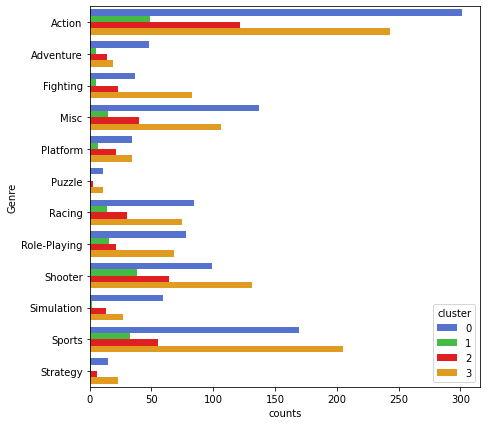

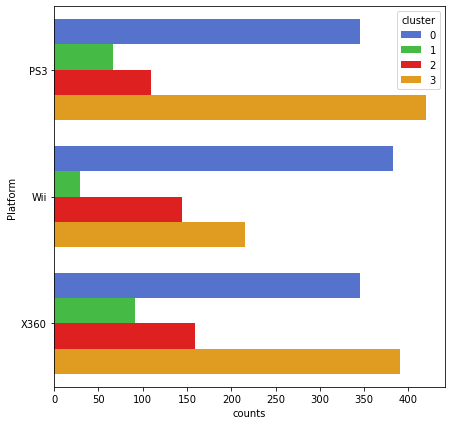

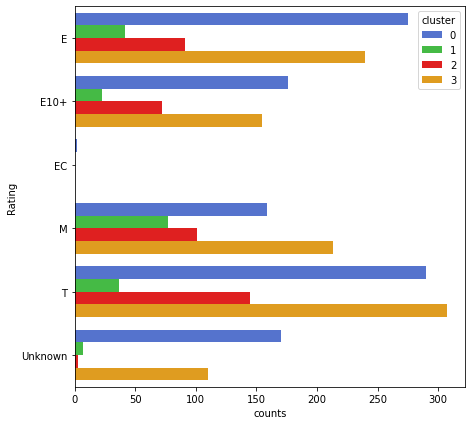

In [48]:
# genres
grouped_by_genre = clustered_data.groupby(["cluster", "Genre"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Genre", hue="cluster", data=grouped_by_genre, orient='h', palette=palette)

# platforms
grouped_by_platform = clustered_data.groupby(["cluster", "Platform"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Platform", hue="cluster", data=grouped_by_platform, orient='h', palette=palette)

# ratings
grouped_by_platform = clustered_data.groupby(["cluster", "Rating"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Rating", hue="cluster", data=grouped_by_platform, orient='h', palette=palette)


### Classification (to clusters)

In [49]:
# prepare dataset
standardize(clustered_data, columns_used_for_clustering, columns_stats)
clustered_data = clustered_data.drop(categorical_columns, axis = 1)

# KNN classification
print("Performing KNN classification - leave one out method")
classification_quality, _ = k_neighbours_leave_one_out(clustered_data, "cluster", 3)
print("Score: {}".format(classification_quality))

# Decision tree classification
print("Performing decision tree classification - leave one out method")
classification_quality, _ = decision_tree_leave_one_out(clustered_data, "cluster")
print("Score: {}".format(classification_quality))


Performing KNN classification - leave one out method
Score: 0.9862708719851577
Performing decision tree classification - leave one out method
Score: 0.9807050092764379
